# Libraries.

In [ ]:
#python functionalities
import os
import pickle
import numpy as np

#display results
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

#T-SNE
import cv2
from sklearn import manifold

#model functionalities
import tensorflow as tf
from keras import regularizers
from keras.models import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, BatchNormalization, Reshape, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

Import the NCIA dataset from Google Drive.

In [ ]:
dir_MCGILL = '/content/drive/My Drive/Bachelor Thesis/Model-Data/128/MCGILL'
dir_MAASTRO = '/content/drive/My Drive/Bachelor Thesis/Model-Data/128/MAASTRO'

# read the training data
with open(dir_MCGILL + '/train_data.pxl', 'rb') as f:
  train_data = np.array(pickle.load(f))
with open(dir_MCGILL + '/train_label.pxl', 'rb') as f:
  train_label = np.array(pickle.load(f))
with open(dir_MCGILL + '/train_contour.pxl', 'rb') as f:
  train_contour = np.array(pickle.load(f))

# read the testing data
with open(dir_MCGILL + '/test_data.pxl', 'rb') as f:
  test_data = np.array(pickle.load(f))
with open(dir_MCGILL + '/test_label.pxl', 'rb') as f:
  test_label = np.array(pickle.load(f))
with open(dir_MCGILL + '/test_contour.pxl', 'rb') as f:
  test_contour = np.array(pickle.load(f))  

Prepare the data.

In [ ]:
#separate labels according to the metastasis type
def vectorize_labels(labels):
  local, distant, death = [], [], []

  for metastasis in labels:
    local.append(metastasis[0])
    distant.append(metastasis[1])
    death.append(metastasis[2])

  return np.asarray(local).astype('float32'), np.asarray(distant).astype('float32'), np.asarray(death).astype('float32')

#normalize the data
train_x = train_data.astype('float32') / 2000.
test_x = test_data.astype('float32') / 2000.

#reshape the data
train_x = np.reshape(train_x, (len(train_x), 128, 128, 1))
test_x  = np.reshape(test_x, (len(test_x), 128, 128, 1))

#generate noise
noise_factor = 0.3
train_x_noisy = train_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_x.shape)
train_x_noisy = np.clip(train_x_noisy, 0., 1.)
test_x_noisy  = test_x + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_x.shape)
test_x_noisy  = np.clip(test_x_noisy, 0., 1.)

#vectorize the labels
train_local, train_distant, train_death = vectorize_labels(train_label)
test_local, test_distant, test_death = vectorize_labels(test_label)

#display data shape
print("Input data shape", train_x.shape)
print("Input label shape", train_local.shape)

Visualize the noisy images.

In [ ]:
scans = 5

plt.figure(figsize=(20, 8))
for i in range(scans):
    # display original
    ax = plt.subplot(2, scans, i + 1)
    plt.imshow(test_x[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, scans, i + scans + 1)
    plt.imshow(test_x_noisy[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Encoder and Decoder.

In [ ]:
def custom_conv2d(layer, filters, stride, name):
  layer = Conv2D(filters, kernel_size=(3,3), strides=stride, activation='relu', padding='same', name=('encoder_conv_%s' % name))(layer)
  layer = BatchNormalization(name=('encoder_bn_%s' % name))(layer)

  return layer

def custom_conv2d_transpose(layer, filters, stride, name):
  layer = Conv2DTranspose(filters, kernel_size=(3,3), strides=stride, activation='relu', padding='same', name=('decoder_conv_%s' % name))(layer)
  layer = BatchNormalization(name=('decoder_bn_%s' % name))(layer)

  return layer

def build_encoder_layers(layer, filters_per_layer):
  for i, filters in enumerate(filters_per_layer):
    layer = custom_conv2d(layer, filters, (1, 1), '1-1_%d' % i)
    layer = custom_conv2d(layer, filters, (1, 1), '1-2_%d' % i)
    layer = custom_conv2d(layer, filters, (2, 2), '2-1_%d' % i)

  return layer

def build_decoder_layers(layer, filters_per_layer):
  for i, filters in enumerate(filters_per_layer[::-1]):
    layer = custom_conv2d_transpose(layer, filters, (2, 2), '2-1_%d' % i)
    layer = custom_conv2d_transpose(layer, filters, (1, 1), '1-2_%d' % i)
    layer = custom_conv2d_transpose(layer, filters, (1, 1), '1-1_%d' % i)

  output = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name=('decoder_conv_output'))(layer)

  return output

Learning parameters.

In [ ]:
#hyper-parameters
epochs_AE = 300
epochs_FULL = 150
batch_size = 64
input_img  = Input(shape=(128, 128, 1))
nb_filters = (32, 64, 128)

#model layers
l = 18

Build the model.

In [ ]:
encoded = build_encoder_layers(input_img, nb_filters)
decoded = build_decoder_layers(encoded, nb_filters)

ae = Model(input_img, decoded)
ae.compile(loss='mean_squared_error', optimizer='rmsprop')
ae.summary()

Train the model.

In [ ]:
hist = ae.fit(train_x_noisy, train_x, 
              batch_size=batch_size,
              epochs=150,
              verbose=2, 
              validation_data=(test_x_noisy, test_x))

#save the model
ae.save('/content/drive/My Drive/Bachelor Thesis/autoencoder_denoising_300.h5')

Autoencoder loss progression.

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(150)

plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Autoencoder Image Reconstruction.

In [ ]:
autoencoder = tf.keras.models.load_model('/content/drive/My Drive/Bachelor Thesis/autoencoder_denoising_300.h5')

decoded_imgs = autoencoder.predict(test_x_noisy)

# number of scans to display
scans = 6

plt.figure(figsize=(20, 10))
for i in range(scans):
    # display corrupted
    ax = plt.subplot(3, scans, i + 1)
    plt.imshow(test_x[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #display original
    ax = plt.subplot(3, scans, i + scans + 1)
    plt.imshow(test_x_noisy[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, scans, i + 2*scans + 1)
    plt.imshow(decoded_imgs[i].reshape(128, 128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Define the fully connected layers that will be stacked up with the encoder function.

In [ ]:
def fc(enco):
  flat = Flatten()(enco)
  drop = Dropout(0.25)(flat)
  den1 = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(drop)
  drop = Dropout(0.5)(den1)
  out  = Dense(1, activation='sigmoid')(drop)
  
  return out

#create augmented image generator
datagen = ImageDataGenerator(rotation_range=45,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest')

#compute quantities required for featurewise normalization
datagen.fit(train_x_noisy)

In [ ]:
model = tf.keras.models.load_model('/content/drive/My Drive/Bachelor Thesis/autoencoder_denoising_300.h5')

def create_model():
  #create the encoder model
  encoder = build_encoder_layers(input_img, nb_filters)
  full_model = Model(input_img, fc(encoder))

  #set layer weights
  for l1, l2 in zip(full_model.layers[:l], model.layers[:l]):
    l1.set_weights(l2.get_weights())
    l1.trainable = False

  #compile the model
  full_model.compile(loss='binary_crossentropy', optimizer='adam')

  return full_model

Train the model.

In [ ]:
tmp_model = create_model()
tmp_model.fit(datagen.flow(train_x_noisy, train_death, batch_size=32), steps_per_epoch=len(train_x) / 32, epochs=100, verbose=0, validation_data=(test_x_noisy, test_death))
pred = tmp_model.predict(test_x_noisy)
fpr, tpr, _ = roc_curve(test_death, pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)
OS_fpr = fpr
OS_tpr = tpr
OS_auc = roc_auc

Classification

<Figure size 576x432 with 0 Axes>

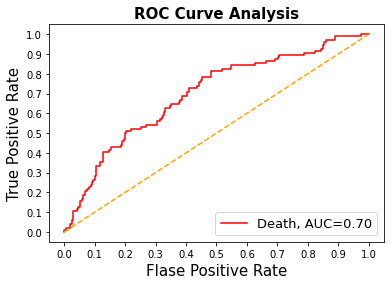

In [ ]:
fig = plt.figure(figsize=(8,6))

plt.figure()
#plt.plot(LR_fpr, LR_tpr, 'blue', label='Local recurrence, AUC={:.2f}'.format(LR_auc))
#plt.plot(DM_fpr, DM_tpr, 'green', label='Distant metastasis, AUC={:.2f}'.format(DM_auc))
plt.plot(OS_fpr, OS_tpr, 'red', label='Death, AUC={:.2f}'.format(OS_auc))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()